Created by Xinlei Gao, Imperial College London, x.gao22@imperial.ac.uk  
This is a test version of internal pressure model of cyclindrical cells. e.g. 21700 


In [1]:
import numpy as np
V_cell = 2.424e-5 # [m3]
Void_ratio = 0.07  
V_void = V_cell * Void_ratio # [m3]

# def Cal_V_jellyroll(t_posCC_0, t_negCC_0, t_pos_0, t_neg_0, t_sep_0, width, height, t_pos_change, t_neg_change):
#     t_pos_change = np.asarray(t_pos_change)
#     t_neg_change = np.asarray(t_neg_change)
    
#     Total_thickness = t_posCC_0 + t_negCC_0 + (t_pos_0 + t_pos_change) + (t_neg_0 + t_neg_change) + t_sep_0
#     Total_volume = Total_thickness * width * height
#     return Total_volume
import numpy as np


def Cal_V_add_SEI(Li_loss_SEI, z_SEI=2):
    V_m_SEI = 1.0797e-4  # m³/mol, to be updated.
    Li_loss_SEI = np.asarray(Li_loss_SEI)
    V_add_SEI = Li_loss_SEI * V_m_SEI / z_SEI
    return V_add_SEI

def Cal_V_add_Li(Li_loss_Li):
    V_m_Li = 1.3e-5  # m³/mol
    Li_loss_Li = np.asarray(Li_loss_Li)
    V_add_Li = Li_loss_Li * V_m_Li
    return V_add_Li

def Cal_V_jellyroll(t_posCC_0, t_negCC_0, t_pos_0, t_neg_0, t_sep_0, width, height, t_pos_change, t_neg_change, Li_loss_SEI=None, Li_loss_Li=None, z_SEI=2):
    t_pos_change = np.asarray(t_pos_change)
    t_neg_change = np.asarray(t_neg_change)
    
    Total_thickness = t_posCC_0 + t_negCC_0 + (t_pos_0 + t_pos_change) + (t_neg_0 + t_neg_change) + t_sep_0
    Total_volume = Total_thickness * width * height
    
    # Calculate V_add_SEI and V_add_Li if provided
    V_add_SEI = Cal_V_add_SEI(Li_loss_SEI, z_SEI) if Li_loss_SEI is not None else np.zeros_like(t_pos_change)
    V_add_Li = Cal_V_add_Li(Li_loss_Li) if Li_loss_Li is not None else np.zeros_like(t_pos_change)
    
    # Add the additional volumes
    Total_volume += V_add_SEI + V_add_Li
    
    return Total_volume

# Example usage:
# Li_loss_SEI = np.array([...])
# Li_loss_Li = np.array([...])
# Total_volume = Cal_V_jellyroll(t_posCC_0, t_negCC_0, t_pos_0, t_neg_0, t_sep_0, width, height, t_pos_change, t_neg_change, Li_loss_SEI, Li_loss_Li)


def Cal_P_gas(V_gas, n_gas_0, T_cell_K_array, n_add_gas=None):
    """
    计算气体压力的函数。

    参数:
    V_gas (array-like): 体积数组，以立方米为单位。
    n_gas_0 (float): 初始气体摩尔数。
    T_cell_K_array (array-like): 温度数组，以开尔文为单位。
    n_add_gas (array-like, optional): 增加的气体摩尔数数组。如果未提供，则默认为全零数组。

    返回:
    array: 气体压力数组，以帕斯卡（Pa）为单位。
    """
    # 确保输入是 NumPy 数组
    V_gas = np.asarray(V_gas)
    T_cell_K_array = np.asarray(T_cell_K_array)
    
    # 检查输入的形状
    if V_gas.shape != T_cell_K_array.shape:
        raise ValueError("输入的 V_gas 和 T_cell_K_array 必须具有相同的形状")
    
    # 如果 n_add_gas 未提供，创建与 V_gas 和 T_cell_K_array 相同形状的全零数组
    if n_add_gas is None:
        n_add_gas = np.zeros_like(V_gas)
    else:
        n_add_gas = np.asarray(n_add_gas)
        if V_gas.shape != n_add_gas.shape:
            raise ValueError("输入的 V_gas、n_add_gas 和 T_cell_K_array 必须具有相同的形状")
    
    # 计算总摩尔数
    n_gas = n_gas_0 + n_add_gas
    
    # 气体常数，单位 J/(mol·K)
    R = 8.314
    
    # 计算气体压力
    pressure = (n_gas * R * T_cell_K_array) / V_gas
    
    return pressure


def Cal_P_elec(T_cell_K_array, ratio_EC, ratio_EMC):
    """
    计算混合电解质蒸汽的部分压力。

    参数:
    T_cell_array (array-like): 温度数组，以开尔文（K）为单位。
    ratio_EC (float): EC 的比例。
    ratio_EMC (float): EMC 的比例。

    返回:
    array: 混合电解质蒸汽的部分压力，以帕斯卡（Pa）为单位。
    """
    
    # Pure EC parameters
    a_EC = 6.4897
    b_EC = 1836.57
    c_EC = -102.23
    
    # Pure EMC parameters
    a_EMC = 6.4308
    b_EMC = 1466.437
    c_EMC = -49.461
    
    # Ensure T_cell_array is a numpy array
    T_cell_K_array = np.asarray(T_cell_K_array)
    
    # Calculate partial pressures
    P_EC = 10 ** (a_EC - (b_EC / (c_EC + T_cell_K_array))) * 1000
    P_EMC = 10 ** (a_EMC - (b_EMC / (c_EMC + T_cell_K_array))) * 1000
    
    # Calculate mixed pressure
    P_mix = ratio_EC * P_EC + ratio_EMC * P_EMC
    
    return P_mix


def Cal_t_from_V(width,height,V_add):
    ##Calculate thickness change due to degradation loss
    t_add = V_add / (width * height)
    return t_add


def add_thickness_changes(t_change_orgin, t_add_SEI=None, t_add_Li=None):
    """
    Function to add t_change with optional t_add_SEI and t_add_Li arrays.
    
    Parameters:
    t_change (array-like): Array of thickness changes.
    t_add_SEI (array-like, optional): Array of additional SEI thickness changes. Default is None.
    t_add_Li (array-like, optional): Array of additional Li thickness changes. Default is None.
    
    Returns:
    numpy.ndarray: Resulting array after adding t_change with t_add_SEI and t_add_Li.
    """
    t_change = np.asarray(t_change_orgin)
    
    if t_add_SEI is not None:
        t_add_SEI = np.asarray(t_add_SEI)
        t_change += t_add_SEI
        
    if t_add_Li is not None:
        t_add_Li = np.asarray(t_add_Li)
        t_change += t_add_Li
    
    return t_change


def Cal_add_gas_SEI(z_SEI, Loss_Li_SEI, coefficient_gas_SEI):
    """
    Function to calculate the additional gases released from SEI growth.
    
    Parameters:
    Loss_Li_SEI: lithium loss to SEI
    z_SEI: If two-electron reaction, then z_SEI =2 
    
    Returns:
    numpy.ndarray: 
    """
    # Simply add a coefficient to fit the gas generation
    n_gas_SEI = coefficient_gas_SEI * Loss_Li_SEI / z_SEI

    return n_gas_SEI

In [2]:
## Test on 1/10C cycling
import pybamm
import matplotlib.pyplot as plt

model = pybamm.lithium_ion.DFN(
    {
        #"particle phases": ("2", "1"),
        #"open-circuit potential": (("single", "current sigmoid"), "single"),
        
        "SEI": "solvent-diffusion limited",
        "SEI porosity change": "true",
        "lithium plating": "partially reversible",
        "lithium plating porosity change": "true",  # alias for "SEI porosity change"
        "particle mechanics": ("swelling and cracking", "swelling only"),
        "SEI on cracks": "true",
        "loss of active material": "stress-driven",
        "calculate discharge energy": "true",  # for compatibility with older PyBaMM versions

        "thermal": "lumped", 
    }
)

param = pybamm.ParameterValues("OKane2022_posmolar_0703")
var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator
    "x_p": 5,  # positive electrode
    "r_n": 30,  # negative particle
    "r_p": 30,  # positive particle
}

cycle_number = 3
exp = pybamm.Experiment(
    # [
    #     "Hold at 4.2 V until C/100 (5 minute period)",
    #     "Rest for 4 hours (5 minute period)",
    #     "Discharge at 0.1C until 2.5 V (5 minute period)",  # initial capacity check
    #     "Charge at 1C until 4.2 V (5 minute period)",
    #     "Hold at 4.2 V until C/100 (5 minute period)",
    # ]
    # + 
    [
        (
            "Discharge at 1C until 2.5 V",  # ageing cycles
            "Charge at 0.3C until 4.2 V (5 minute period)",
            "Hold at 4.2 V until C/100 (5 minute period)",
        )
    ]
    * cycle_number
    #+ ["Discharge at 0.1C until 2.5 V (5 minute period)"],  # final capacity check
)

# exp = pybamm.Experiment(
#     [
#         "Hold at 4.2 V until C/100 (5 minute period)",
#         "Discharge at 0.1C until 2.5 V (5 minute period)",  # initial capacity check
#         "Charge at 0.1C until 4.2 V (5 minute period)",
#         "Hold at 4.2 V until C/100 (5 minute period)",
#     ]
# )


sim = pybamm.Simulation(model, parameter_values=param, experiment=exp, var_pts=var_pts)
#sim_thermal = pybamm.Simulation(model_thermal, parameter_values=param, experiment=exp, var_pts=var_pts)
sol = sim.solve()
#sol_thermal = sim_thermal.solve()



At t = 494.796 and h = 9.2177e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 375.902 and h = 6.42015e-10, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 210.094 and h = 1.1506e-11, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 449.071 and h = 9.37804e-12, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 136.437 and h = 2.71129e-10, the corrector convergence failed repeatedly or with |h| = hmin.


In [3]:

t_posCC_0 = param["Positive current collector thickness [m]"]
t_negCC_0 = param["Negative current collector thickness [m]"]
t_pos_0 = param["Positive electrode thickness [m]"]
t_neg_0 = param["Negative electrode thickness [m]"]
t_sep_0 = param["Separator thickness [m]"]
width = param["Electrode width [m]"]
height = param["Electrode height [m]"]
t_pos_change = sol["Positive electrode thickness change [m]"].entries
t_neg_change = sol["Negative electrode thickness change [m]"].entries
# Thickness change variable obtained from PyBaMM source code

t_total_change_origin = sol["Cell thickness change [m]"].entries #noted SEI and Li plating directly goes to volume for calculating pressure 

Li_loss_SEI = sol["Loss of lithium to negative SEI [mol]"].entries + sol["Loss of lithium to negative SEI on cracks [mol]"].entries
V_add_SEI = Cal_V_add_SEI(Li_loss_SEI=Li_loss_SEI,z_SEI=2)
Li_loss_Li = sol["Loss of lithium to negative lithium plating [mol]"].entries
V_add_Li = Cal_V_add_Li(Li_loss_Li=Li_loss_Li)

# Calculate addtional gas from side reactions
n_gas_SEI = Cal_add_gas_SEI(Loss_Li_SEI=Li_loss_SEI, z_SEI=2, coefficient_gas_SEI=0.2) # Simplest assumption, no decay

# Calculate thickness change due to degradation/ side reactions 
t_SEI = Cal_t_from_V(width=width,height=height,V_add=V_add_SEI)
t_Li = Cal_t_from_V(width=width,height=height,V_add=V_add_Li)

t_total_change = add_thickness_changes(t_change_orgin=t_total_change_origin,t_add_SEI=t_SEI,t_add_Li=t_Li)

T_cell_K = sol["X-averaged cell temperature [K]"].entries
T_cell_C = sol["X-averaged cell temperature [C]"].entries
V_jellyroll = Cal_V_jellyroll(t_posCC_0,t_negCC_0,t_pos_0,t_neg_0,t_sep_0,width,height,
                              t_pos_change,t_neg_change,Li_loss_SEI=Li_loss_SEI,Li_loss_Li=Li_loss_Li,z_SEI=2)

V_void = V_cell - V_jellyroll



n_0 = 2e-4 # [mol]
##n_add_gas = 0 #不传入n_add_gas
#P_gas = Cal_P_gas(V_gas=V_void, n_gas_0=n_0, T_cell_K_array= T_cell_K) 
P_gas = Cal_P_gas(V_gas=V_void, n_gas_0=n_0, T_cell_K_array= T_cell_K,n_add_gas=n_gas_SEI) 

P_elec = Cal_P_elec(T_cell_K_array=T_cell_K, ratio_EC=0.3, ratio_EMC=0.7) # EC:EMC = 3:7

P_cell = P_gas + P_elec

P_bar = 101325 # Pa->bar
P_cell_bar = P_cell/P_bar

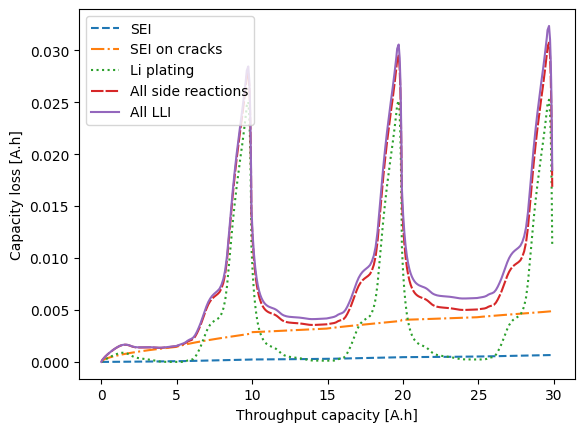

In [4]:
Qt = sol["Throughput capacity [A.h]"].entries
Q_SEI = sol["Loss of capacity to negative SEI [A.h]"].entries
Q_SEI_cr = sol["Loss of capacity to negative SEI on cracks [A.h]"].entries
Q_plating = sol["Loss of capacity to negative lithium plating [A.h]"].entries
Q_side = sol["Total capacity lost to side reactions [A.h]"].entries
Q_LLI = (
    sol["Total lithium lost [mol]"].entries * 96485.3 / 3600
)  # convert from mol to A.h

plt.figure()
plt.plot(Qt, Q_SEI, label="SEI", linestyle="dashed")
plt.plot(Qt, Q_SEI_cr, label="SEI on cracks", linestyle="dashdot")
plt.plot(Qt, Q_plating, label="Li plating", linestyle="dotted")
plt.plot(Qt, Q_side, label="All side reactions", linestyle=(0, (6, 1)))
plt.plot(Qt, Q_LLI, label="All LLI")
plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Capacity loss [A.h]")
plt.legend()
plt.show()

In [5]:
time = sol["Time [min]"].entries
Voltage = sol["Terminal voltage [V]"].entries

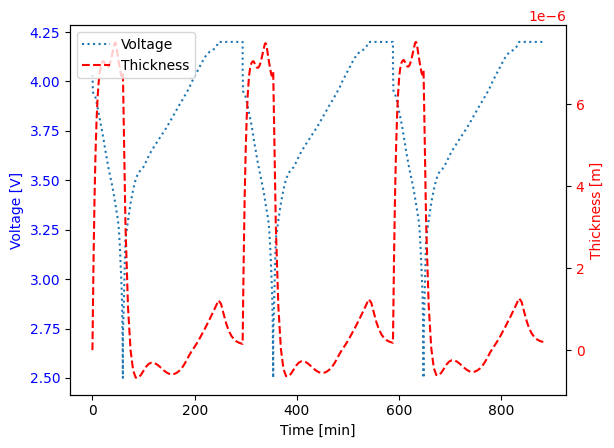

In [6]:
import matplotlib.pyplot as plt

# 假设 Qt, Voltage 和 Thickness 是已经定义的数据
# 例如：
# Qt = [1, 2, 3, 4, 5]
# Voltage = [2.1, 2.3, 2.2, 2.5, 2.7]
# Thickness = [0.1, 0.15, 0.13, 0.18, 0.2]

# 创建图形和主轴
plt.figure()
ax1 = plt.gca()  # 获取当前轴

# 在主轴上绘制 Voltage
ax1.plot(time, Voltage, label="Voltage", linestyle="dotted")
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Voltage [V]", color='b')  # 设置颜色和标签以区分
ax1.tick_params(axis='y', labelcolor='b')  # 设置刻度颜色

# 创建与主轴共享x轴的次轴
ax2 = ax1.twinx()  # 创建次要的y轴
ax2.plot(time, t_total_change, label="Thickness", linestyle="dashed", color='r')  # 在次轴上绘制 Thickness
ax2.set_ylabel("Thickness [m]", color='r')  # 设置颜色和标签以区分
ax2.tick_params(axis='y', labelcolor='r')  # 设置刻度颜色

# 添加图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

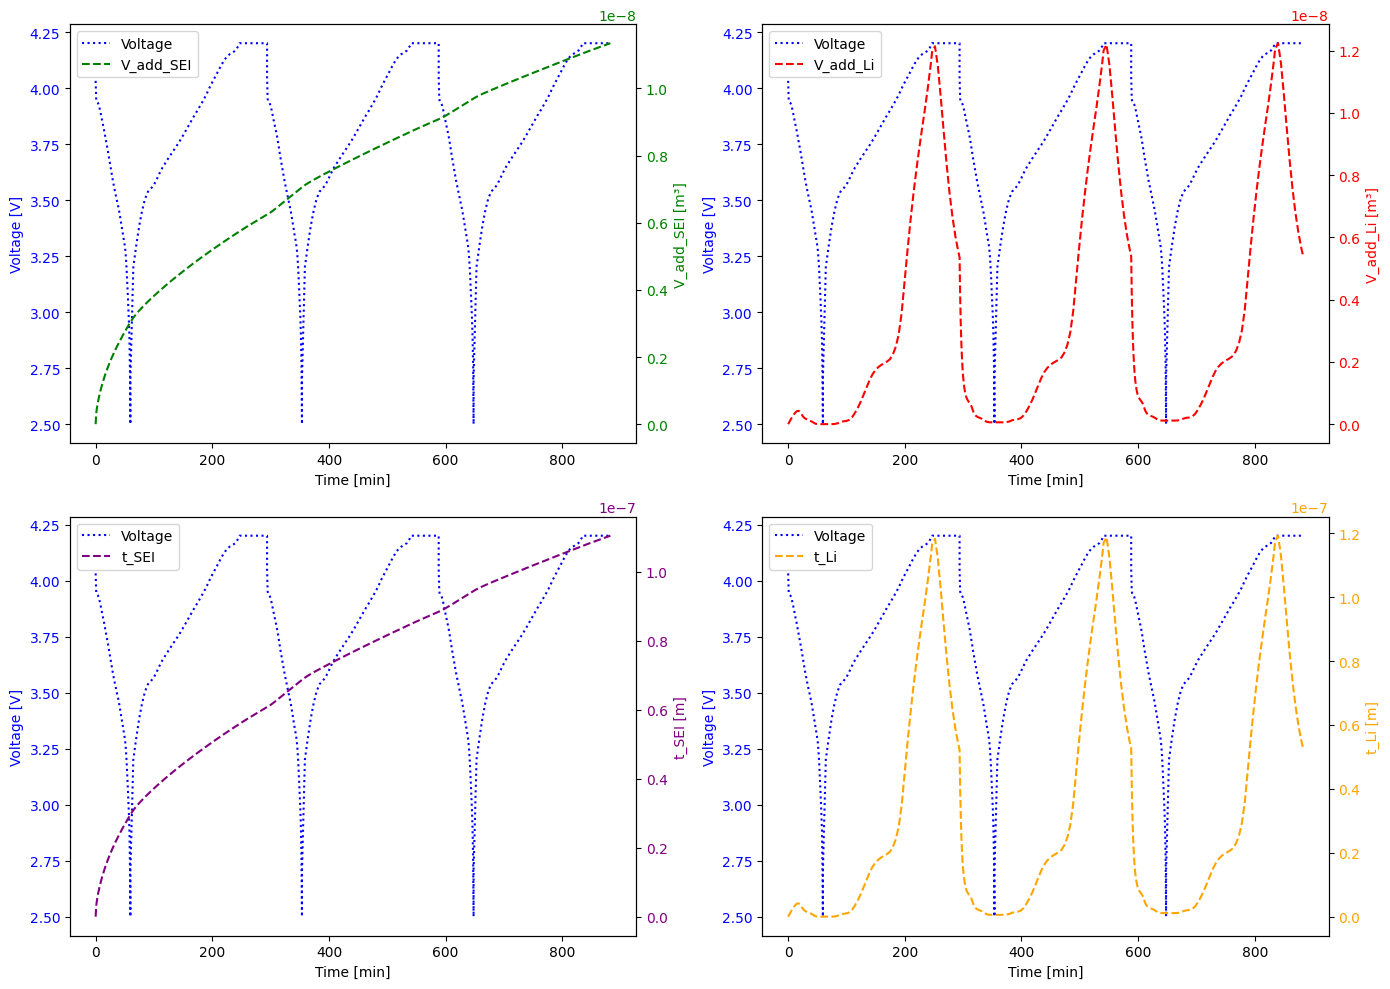

In [7]:
# 创建图形和主轴
fig, ((ax1, ax3), (ax5, ax7)) = plt.subplots(2, 2, figsize=(14, 10))

# 左上图
ax1.plot(time, Voltage, label="Voltage", linestyle="dotted", color='b')
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Voltage [V]", color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(time, V_add_SEI, label="V_add_SEI", linestyle="dashed", color='g')
ax2.set_ylabel("V_add_SEI [m³]", color='g')
ax2.tick_params(axis='y', labelcolor='g')

# 添加图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# 右上图
ax3.plot(time, Voltage, label="Voltage", linestyle="dotted", color='b')
ax3.set_xlabel("Time [min]")
ax3.set_ylabel("Voltage [V]", color='b')
ax3.tick_params(axis='y', labelcolor='b')

ax4 = ax3.twinx()
ax4.plot(time, V_add_Li, label="V_add_Li", linestyle="dashed", color='r')
ax4.set_ylabel("V_add_Li [m³]", color='r')
ax4.tick_params(axis='y', labelcolor='r')

# 添加图例
lines3, labels3 = ax3.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
ax3.legend(lines3 + lines4, labels3 + labels4, loc='upper left')

# 左下图
ax5.plot(time, Voltage, label="Voltage", linestyle="dotted", color='b')
ax5.set_xlabel("Time [min]")
ax5.set_ylabel("Voltage [V]", color='b')
ax5.tick_params(axis='y', labelcolor='b')

ax6 = ax5.twinx()
ax6.plot(time, t_SEI, label="t_SEI", linestyle="dashed", color='purple')
ax6.set_ylabel("t_SEI [m]", color='purple')
ax6.tick_params(axis='y', labelcolor='purple')

# 添加图例
lines5, labels5 = ax5.get_legend_handles_labels()
lines6, labels6 = ax6.get_legend_handles_labels()
ax5.legend(lines5 + lines6, labels5 + labels6, loc='upper left')

# 右下图
ax7.plot(time, Voltage, label="Voltage", linestyle="dotted", color='b')
ax7.set_xlabel("Time [min]")
ax7.set_ylabel("Voltage [V]", color='b')
ax7.tick_params(axis='y', labelcolor='b')

ax8 = ax7.twinx()
ax8.plot(time, t_Li, label="t_Li", linestyle="dashed", color='orange')
ax8.set_ylabel("t_Li [m]", color='orange')
ax8.tick_params(axis='y', labelcolor='orange')

# 添加图例
lines7, labels7 = ax7.get_legend_handles_labels()
lines8, labels8 = ax8.get_legend_handles_labels()
ax7.legend(lines7 + lines8, labels7 + labels8, loc='upper left')

plt.tight_layout()
plt.show()

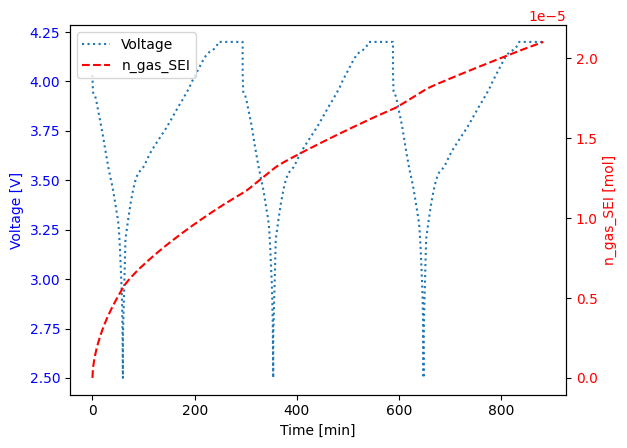

In [8]:
import matplotlib.pyplot as plt

# 假设 Qt, Voltage 和 Thickness 是已经定义的数据
# 例如：
# Qt = [1, 2, 3, 4, 5]
# Voltage = [2.1, 2.3, 2.2, 2.5, 2.7]
# Thickness = [0.1, 0.15, 0.13, 0.18, 0.2]

# 创建图形和主轴
plt.figure()
ax1 = plt.gca()  # 获取当前轴

# 在主轴上绘制 Voltage
ax1.plot(time, Voltage, label="Voltage", linestyle="dotted")
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Voltage [V]", color='b')  # 设置颜色和标签以区分
ax1.tick_params(axis='y', labelcolor='b')  # 设置刻度颜色

# 创建与主轴共享x轴的次轴
ax2 = ax1.twinx()  # 创建次要的y轴
ax2.plot(time, n_gas_SEI, label="n_gas_SEI", linestyle="dashed", color='r')  # 在次轴上绘制 Thickness
ax2.set_ylabel("n_gas_SEI [mol]", color='r')  # 设置颜色和标签以区分
ax2.tick_params(axis='y', labelcolor='r')  # 设置刻度颜色

# 添加图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

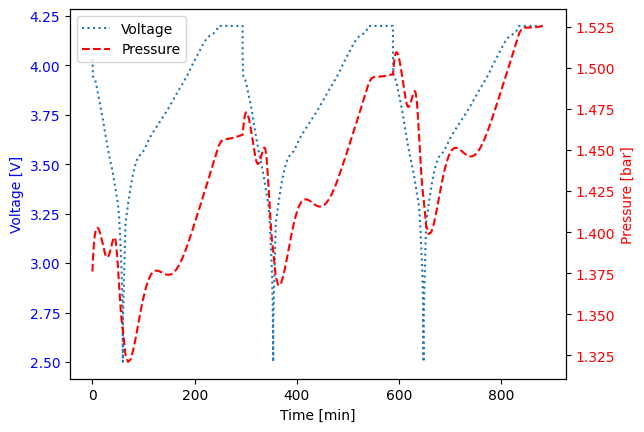

In [9]:
import matplotlib.pyplot as plt

# 假设 Qt, Voltage 和 Thickness 是已经定义的数据
# 例如：
# Qt = [1, 2, 3, 4, 5]
# Voltage = [2.1, 2.3, 2.2, 2.5, 2.7]
# Thickness = [0.1, 0.15, 0.13, 0.18, 0.2]

# 创建图形和主轴
plt.figure()
ax1 = plt.gca()  # 获取当前轴

# 在主轴上绘制 Voltage
ax1.plot(time, Voltage, label="Voltage", linestyle="dotted")
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Voltage [V]", color='b')  # 设置颜色和标签以区分
ax1.tick_params(axis='y', labelcolor='b')  # 设置刻度颜色

# 创建与主轴共享x轴的次轴
ax2 = ax1.twinx()  # 创建次要的y轴
ax2.plot(time, P_cell_bar, label="Pressure", linestyle="dashed", color='r')  # 在次轴上绘制 Thickness
ax2.set_ylabel("Pressure [bar]", color='r')  # 设置颜色和标签以区分
ax2.tick_params(axis='y', labelcolor='r')  # 设置刻度颜色

# 添加图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

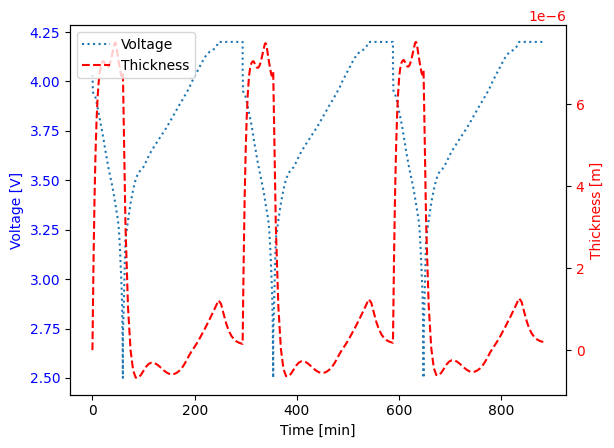

In [10]:
## thermal 
plt.figure()
ax1 = plt.gca()  # 获取当前轴

# 在主轴上绘制 Voltage
ax1.plot(time, Voltage, label="Voltage", linestyle="dotted")
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Voltage [V]", color='b')  # 设置颜色和标签以区分
ax1.tick_params(axis='y', labelcolor='b')  # 设置刻度颜色

# 创建与主轴共享x轴的次轴
ax2 = ax1.twinx()  # 创建次要的y轴
ax2.plot(time, t_total_change , label="Thickness", linestyle="dashed", color='r')  # 在次轴上绘制 Thickness
ax2.set_ylabel("Thickness [m]", color='r')  # 设置颜色和标签以区分
ax2.tick_params(axis='y', labelcolor='r')  # 设置刻度颜色

# 添加图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

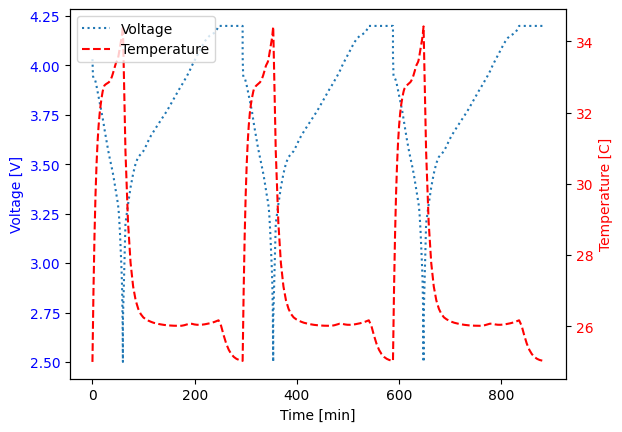

In [11]:
## thermal 
plt.figure()
ax1 = plt.gca()  # 获取当前轴

# 在主轴上绘制 Voltage
ax1.plot(time, Voltage, label="Voltage", linestyle="dotted")
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Voltage [V]", color='b')  # 设置颜色和标签以区分
ax1.tick_params(axis='y', labelcolor='b')  # 设置刻度颜色

# 创建与主轴共享x轴的次轴
ax2 = ax1.twinx()  # 创建次要的y轴
ax2.plot(time, T_cell_C, label="Temperature", linestyle="dashed", color='r')  # 在次轴上绘制 Thickness
ax2.set_ylabel("Temperature [C]", color='r')  # 设置颜色和标签以区分
ax2.tick_params(axis='y', labelcolor='r')  # 设置刻度颜色

# 添加图例
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.show()

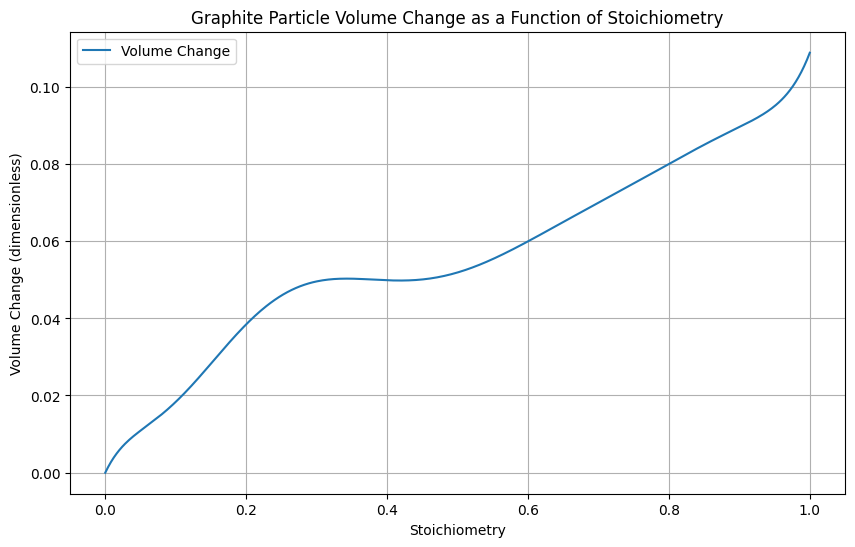

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def graphite_volume_change_Ai2020(sto):
    """
    Graphite particle volume change as a function of stochiometry [1, 2].

    References
    ----------
     .. [1] Ai, W., Kraft, L., Sturm, J., Jossen, A., & Wu, B. (2020).
     Electrochemical Thermal-Mechanical Modelling of Stress Inhomogeneity in
     Lithium-Ion Pouch Cells. Journal of The Electrochemical Society, 167(1), 013512
      DOI: 10.1149/2.0122001JES.
     .. [2] Rieger, B., Erhard, S. V., Rumpf, K., & Jossen, A. (2016).
     A new method to model the thickness change of a commercial pouch cell
     during discharge. Journal of The Electrochemical Society, 163(8), A1566-A1575.

    Parameters
    ----------
    sto: :class:`numpy.ndarray`
        Electrode stochiometry, dimensionless
        should be R-averaged particle concentration

    Returns
    -------
    t_change: :class:`numpy.ndarray`
        volume change, dimensionless, normalised by particle volume
    """
    p1 = 145.907
    p2 = -681.229
    p3 = 1334.442
    p4 = -1415.710
    p5 = 873.906
    p6 = -312.528
    p7 = 60.641
    p8 = -5.706
    p9 = 0.386
    p10 = -4.966e-05
    t_change = (
        p1 * sto**9
        + p2 * sto**8
        + p3 * sto**7
        + p4 * sto**6
        + p5 * sto**5
        + p6 * sto**4
        + p7 * sto**3
        + p8 * sto**2
        + p9 * sto
        + p10
    )
    return t_change

# Define the range of stoichiometry
sto = np.linspace(0, 1, 500)

# Calculate the volume change
volume_change = graphite_volume_change_Ai2020(sto)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sto, volume_change, label='Volume Change')
plt.xlabel('Stoichiometry')
plt.ylabel('Volume Change (dimensionless)')
plt.title('Graphite Particle Volume Change as a Function of Stoichiometry')
plt.legend()
plt.grid(True)
plt.show()


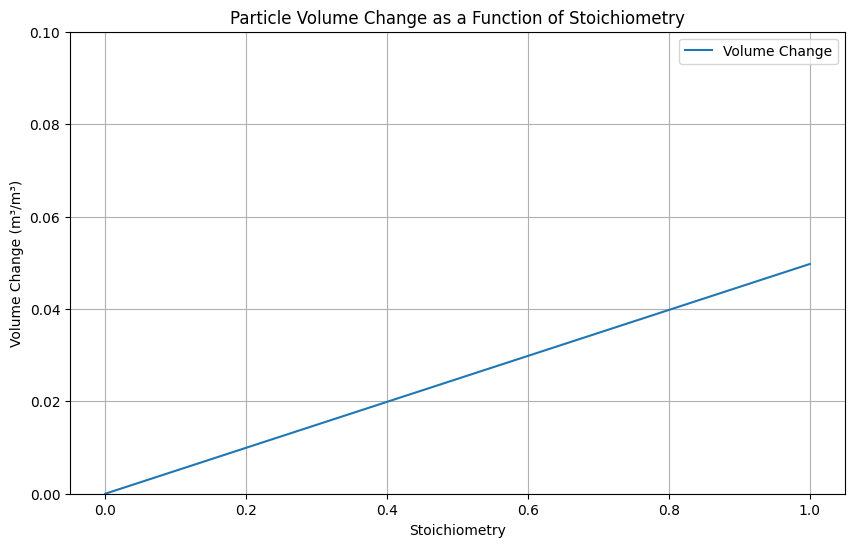

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def volume_change_Ai2020(sto, c_s_max):
    """
    Particle volume change as a function of stochiometry [1, 2].

    References
    ----------
     .. [1] Ai, W., Kraft, L., Sturm, J., Jossen, A., & Wu, B. (2020).
     Electrochemical Thermal-Mechanical Modelling of Stress Inhomogeneity in
     Lithium-Ion Pouch Cells. Journal of The Electrochemical Society, 167(1), 013512
      DOI: 10.1149/2.0122001JES.
     .. [2] Rieger, B., Erhard, S. V., Rumpf, K., & Jossen, A. (2016).
     A new method to model the thickness change of a commercial pouch cell
     during discharge. Journal of The Electrochemical Society, 163(8), A1566-A1575.

    Parameters
    ----------
    sto: :class:`numpy.ndarray`
        Electrode stochiometry, dimensionless
        should be R-averaged particle concentration
    c_s_max: float
        Maximum concentration in positive electrode [mol.m-3]

    Returns
    -------
    t_change: :class:`numpy.ndarray`
        Volume change, dimensionless, normalised by particle volume
    """
    omega = 7.88e-07  # Positive electrode partial molar volume [m3.mol-1]
    t_change = omega * c_s_max * sto
    return t_change

# Define the range of stoichiometry
sto = np.linspace(0, 1, 500)
c_s_max = 63104.0  # Maximum concentration in positive electrode [mol.m-3]

# Calculate the volume change
volume_change = volume_change_Ai2020(sto, c_s_max)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(sto, volume_change, label='Volume Change')
plt.xlabel('Stoichiometry')
plt.ylabel('Volume Change (m³/m³)')
plt.ylim(0,0.1)
plt.title('Particle Volume Change as a Function of Stoichiometry')
plt.legend()
plt.grid(True)
plt.show()
